In [1]:
%matplotlib inline

In [2]:
import serial, threading, sys, time
sys.path.append('/home/pi/Desktop/ADR_NX/Utils')
sys.path.append('/home/pi/Desktop/ADR_NX/Mainframe')
from adr_PID import ADR_PID
import adr_utils, SIM900_controller, SIM921, SIM922, SIM960
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from HCLib import HeaterController

In [3]:
debug = 1
HC = HeaterController.HeaterController()
HC.debug = 0
HC.establish_comms()

In [4]:
mfc = SIM900_controller.SIM900()
mfc.init_and_open_connection()
mfc.start_input_loop()
mfc.start_output_loop()
s921 = SIM921.SIM921(mfc)
s922 = SIM922.SIM922(mfc)
s960 = SIM960.SIM960(mfc)

Input loop started
Input read thread is up!
Output loop started


In [5]:
HC.set_dutycycle(0)
HC.set_onoff(0)
mfc.get_serial_object().write("SNDT 6,\"SOUT\n\"\n")

15

In [6]:
mfc.get_IDN()
mfc.set_RPER([s921.MODNUM, s922.MODNUM, s960.MODNUM])

OQADD (t:0): |*IDN?\n|
OQSEND (t:0): |*IDN?\n|
Read line: 'Stanford_Research_Systems,SIM900,s/n130132,ver3.6\r\n'
GOT MSG -> S0:'Stanford_Research_Systems,SIM900,s/n130132,ver3.6'
GOT RESP IN 0.096184015274
OQADD (t:0): |RPER 74\n|
OQSEND (t:0): |RPER 74\n|


In [7]:
s922.start_data_stream()
s922.newdataevent.wait(20)
time.sleep(1)
s922.stop_data_stream()

OQADD (t:0): |SNDT 6,"TVAL? 4,0\n"\n|OQSEND (t:0): |SNDT 6,"TVAL? 4,0\n"\n|

Read line: 'MSG 6,#2142.972000E+00\r\n'
GOT MSG -> S6:'2.972000E+00'
Got temperature data: 2.972000E+00|17:58:30.489652
Blank line ignored!
Read line: 'MSG 6,#2142.972000E+00\r\n'
GOT MSG -> S6:'2.972000E+00'
Got temperature data: 2.972000E+00|17:58:31.288751
Blank line ignored!
OQADD (t:0): |SNDT 6,"SOUT \n"\n|
OQSEND (t:0): |SNDT 6,"SOUT \n"\n|


In [8]:
s921.start_data_stream()
s921.newdataevent.wait(20)
time.sleep(1)
s921.stop_data_stream()

OQADD (t:0): |SNDT 1,"TVAL? 0\n"\n|
OQSEND (t:0): |SNDT 1,"TVAL? 0\n"\n|
Read line: 'MSG 1,#215+1.249154E-01\r\n'
GOT MSG -> S1:'+1.249154E-01'
Got temperature data: +1.249154E-01|17:58:46.557722
Blank line ignored!
OQADD (t:0): |SNDT 1,"SOUT \n"\n|
OQSEND (t:0): |SNDT 1,"SOUT \n"\n|


In [18]:
from IPython.display import clear_output
P = 7.0
I = 0.05
D = 0.1
pid = ADR_PID(P,I,D,0)
pid.SetPoint = 20.0
pid.setSlewLimit(0.5)
s922.start_data_stream()
s921.start_data_stream()
HC.set_onoff(1)
start = timer()

temps = []
times = []
temps_st = []
for i in range(1,1200):    
    s922.newdataevent.wait(5)
    s922.newdataevent.clear()
    
    temp_st = s921.lasttemperature
    temps_st.append(temp_st)
    
    temp = s922.lasttemperature
    if (temp > 40.0):
        continue
        #raise IOError("WRONG TEMP?")
    else:        
        if (time == s922.lastdatatime):
            HC.set_onoff(0)
            s922.stop_data_stream()
            #raise IOError("STUCK")
        time = s922.lastdatatime
        temps.append(temp)
        times.append(timer()-start)    
        pid.update(temp)
        output = pid.output
        if output < 0.0 or output > 100.0:
            continue
        else:
            HC.set_dutycycle(output)
    print("{}|{}|{}".format(str(output),str(temp),str(i)))
    if i%5 == 0:
        clear_output()
    
HC.set_onoff(0)
s922.stop_data_stream()
s921.stop_data_stream()

Read line: 'MSG 6,#2142.006700E+01\r\n'
Blank line ignored!
GOT MSG -> S6:'2.006700E+01'
Got temperature data: 2.006700E+01|18:58:57.676164
5.50712030455|20.067|1196
Read line: 'MSG 1,#215+1.722018E-01\r\n'
GOT MSG -> S1:'+1.722018E-01'
Got temperature data: +1.722018E-01|18:58:58.162149
Blank line ignored!
Read line: 'MSG 6,#2142.006700E+01\r\n'
GOT MSG -> S6:'2.006700E+01'
Got temperature data: 2.006700E+01|18:58:58.465977
Blank line ignored!
5.50459193974|20.067|1197
Read line: 'MSG 6,#2142.006700E+01\r\n'
Blank line ignored!
GOT MSG -> S6:'2.006700E+01'
Got temperature data: 2.006700E+01|18:58:59.264236
5.50195799227|20.067|1198
Read line: 'MSG 6,#2142.006800E+01\r\n'
Blank line ignored!
GOT MSG -> S6:'2.006800E+01'
Got temperature data: 2.006800E+01|18:59:00.073978
5.49215697685|20.068|1199
OQADD (t:0): |SNDT 6,"SOUT \n"\n|
OQSEND (t:0): |SNDT 6,"SOUT \n"\n|OQADD (t:0): |SNDT 1,"SOUT \n"\n|

Read line: 'MSG 1,#215+1.718597E-01\r\n'
OQSEND (t:0): |SNDT 1,"SOUT \n"\n|
GOT MSG -> S1:

In [17]:
s922.stop_data_stream()
s921.stop_data_stream()
mfc.get_serial_object().write("SNDT 6,\"SOUT\n\"\n")

OQSEND (t:0): |SNDT 6,"SOUT \n"\n|OQADD (t:0): |SNDT 6,"SOUT \n"\n|

OQADD (t:0): |SNDT 1,"SOUT \n"\n|


15

OQSEND (t:0): |SNDT 1,"SOUT \n"\n|


In [ ]:
HC.set_onoff(0)
s922.stop_data_stream()

In [23]:
t1 = [x if x> 8 else 20.0 for x in temps]
t2 = [x if x< 0.2 else 0.170 for x in temps_st]
t2 = [x if x> 0.112 else 0.170 for x in t2]

In [21]:
type(times)

list

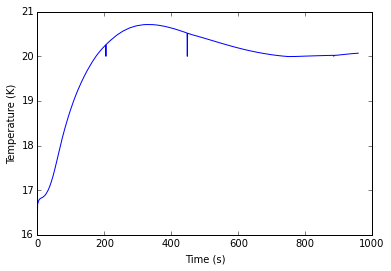

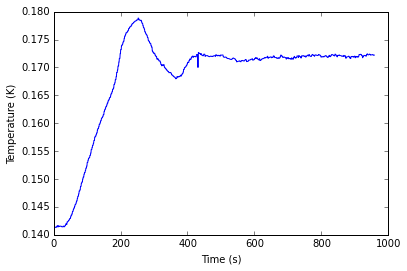

In [24]:
fig = plt.figure()
plt.plot(times,t1,'-')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

fig = plt.figure()
plt.plot(times,t2,'-')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

In [ ]:
from IPython.display import clear_output
s921.start_data_stream()
start = timer()
temps = []
times = []
for i in range(1,50):    
    s921.newdataevent.wait(5)
    s921.newdataevent.clear()
    temp = s921.lasttemperature    
    if (temp > 40.0):
        raise IOError("WRONG TEMP?")
    if (time == s921.lastdatatime):
        HC.set_onoff(0)
        s921.stop_data_stream()
        raise IOError("STUCK")
    time = s921.lastdatatime
    
    temps.append(temp)
    times.append(timer()-start)
    print("{}|{}|{}".format(temp,time,i))
    if i%10 == 0:
        clear_output()
    
s921.stop_data_stream()

In [ ]:
fig = plt.figure()
plt.plot(times,temps,'-')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()
fig = plt.figure()
plt.plot(times[-50:],temps[-50:],'-')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.show()

In [ ]:
mfc.stop_input_loop()
mfc.stop_output_loop()

In [ ]:
s921.stop_data_stream()
mfc.get_serial_object().write("SNDT 1,\"SOUT\n\"\n")